# Initializations

In [2]:
ip = '192.168.137.1'
expt_path = 'C:\\_Data\\LLotsa\\Tuning_2025_01_11\\'
cfg_file='llotsa05.yml'

import sys
#pt = '\\experiments\\gen'
#sys.path.append(pt)

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from qick import *
import os
import time 
from exp_handling.instrumentmanager import InstrumentManager
import experiments as meas
import config
import qubit_tuning
import tuneup
import handy
import seaborn as sns

colors = ["#0869c8","#b51d14"]
sns.set_palette(sns.color_palette(colors))

# Figure params
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams.update({'font.size': 11})
print('Data will be stored in', expt_path)

# # check if we need this. 
# import importlib 
# importlib.reload(meas)

# Results config file:
cfg_path = os.getcwd() + '\\configs\\' + cfg_file
auto_cfg = config.load(cfg_path)

# Connect to instruments 
im = InstrumentManager(ns_address=ip)#, config_path='instruments.cfg') # BF5
print(im)
soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)

num_qubits = len(auto_cfg.device.qubit.f_ge)
cfg_dict = {'soc':soc, 'expt_path':expt_path, 'cfg_file':cfg_path, 'im':im}

max_t1 = 75

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
imported experiments.single_qubit.inactive
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.rabi
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t1_doub
imported experiments.single_qubit.t1_stark
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.single_qubit.t2_ramsey_stark
imported experiments.two_qubit.rabi_2q
imported experiments.two_qubit.t1_2q
Data will be stored in C:\_Data\LLotsa\Tuning_2025_01_11\
{'Pyro.NameServer': <Pyro4.core.Proxy at 0x13c8e8735b0; not connected; for PYRO:Pyro.NameServer@192.168.137.1:9090>, 'Qick233': <Pyro4.core.Proxy at 0x13c8e8733a0; not connected; for PYRO:obj_97df5a59f6224d0f9572441918c8

## Set up new config or data folder

In [ ]:
new_config = False
new_folder = False

if new_config or new_folder:
    expt_path = 'C:\\_Data\\LLotsa\\Tuning_2024_12_20_tprocv2\\'
    if new_config:
        cfg_file='llotsa05.yml'
        config.init_config( os.getcwd() + '\\configs\\' + cfg_file, 20, type='full', aliases='Qick233', t1=30)

    os.mkdir(expt_path)
    os.mkdir(expt_path + 'images')
    os.mkdir(expt_path + 'images\\summary')

## Signalcore init

In [ ]:
sc1 = im['SC1']
sc2 = im['SC2']

sc1.open_device()
sc2.open_device()

def set_frequency(sc, freq):
    sc.set_standby(enable = True)
    sc1.set_frequency(freq*1e6)
    sc2.set_standby(enable = False)
    time.sleep(5)

def set_power(sc, power):
    sc.set_standby(enable = True)

    sc.set_power(power)
    sc.set_standby(enable = False)

    time.sleep(5)

In [ ]:
sc1.set_power(13)
sc2.set_power(13)

In [ ]:
sc1
sc1.close_device()

## Check QICK mirror frequencies

In [ ]:
import qick_check

qick_check.check_freqs(3, cfg_dict['cfg_file'])

Note: make sure you set your ADC/DAC channels correctly. This code does not automatically fill in the ADC/DAC into your configuration file, so you should check yourself to make sure these values are correct. 

# Time of Flight (TOF)

TOF measures the time it takes for the signal to run through the wires. It will give us the time in clock ticks that we should wait to make a measurements 

check


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving C:\_Data\LLotsa\Tuning_2025_01_11\adc_trig_offset_calibration_qubit0_00001.h5
Saving C:\_Data\LLotsa\Tuning_2025_01_11\adc_trig_offset_calibration_qubit0_00001.h5


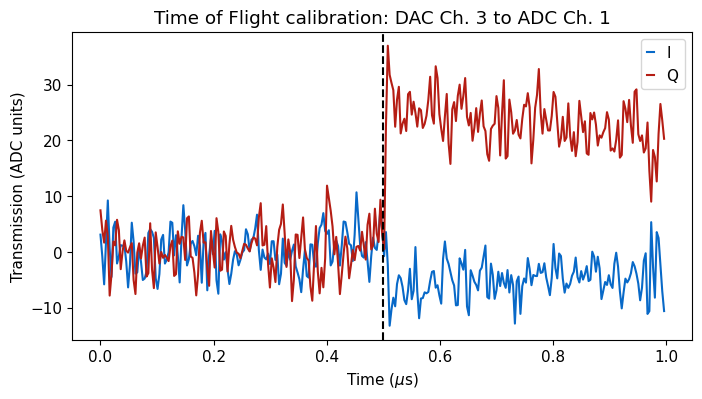

In [6]:

tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=0)

# Resonator Spectroscopy 

Run resonator spectroscopy for all resonators by choosing a large frequency scan to look over. The scan will then find the different resonators and fill in the config file with their respective frequencies. In the autocalibration, there will be a finer sweep of each resonator to more accurately find its frequency. The frequencies are saved in <code>auto_cfg.device.readout.frequency</code>

## Coarse 

This will perform peak finding

In [ ]:
#rspec = cfg.make_rspec_coarse(soc, expt_path, cfg_path, i, im=im, start=6000, span=800, reps=2000, npts=5000)
qi=10
rspecc = meas.ResSpec(cfg_dict, qi=qi, style='coarse', params={'start':950, 'span':2200, 'soft_avgs':1, 'reps':1500, 'gain':0.23, 'expts':5000})
res_values = rspecc.data['coarse_peaks']

Change prom (prominence value) to adjust how to find the peaks

In [ ]:
rspecc.analyze(peaks=True, debug=True, fit=False, prom=0.05)
rspecc.display(peaks=True, fit=False)
res_values = rspecc.data['coarse_peaks']

Can delete values from res_values if they don't seem to be real res_values. 

In [23]:
res_values = np.delete(res_values,1)

## Fine

### Two versions; with kappa/freq or from initial search

  0%|          | 0/28400 [00:00<?, ?it/s]

Saving C:\_Data\LLotsa\Tuning_2025_01_11\resonator_spectroscopy_fine_qubit10_00044.h5


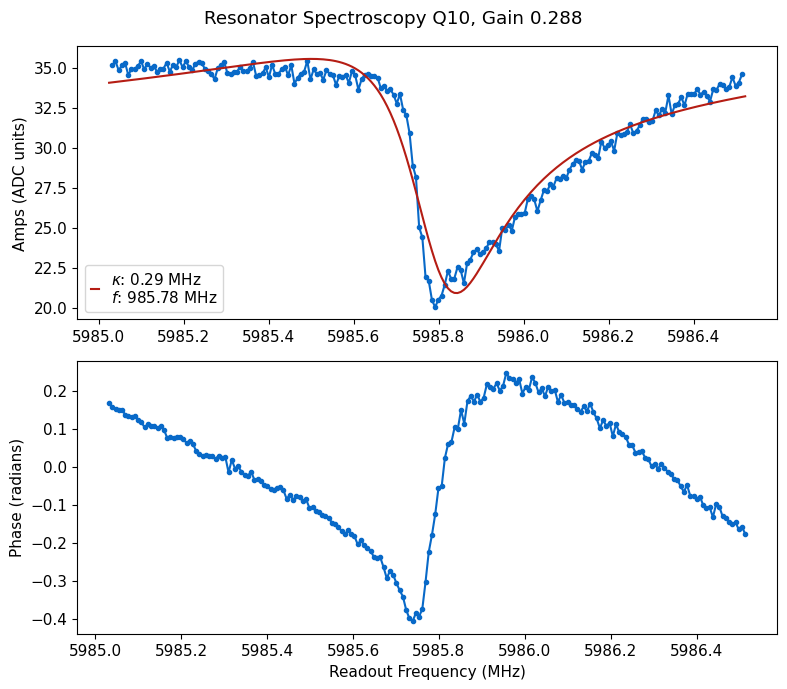

*Set cfg readout 10 frequency to 985.7914 from 985.7743*
*Set cfg readout 10 qi to 3.8151 from 3.6074*
*Set cfg readout 10 qe to 4.6632 from 4.5309*
*Set cfg readout 10 kappa to 0.2853 from 0.298*


In [12]:
# Just run one  
qubit_list = np.arange(20)
update=True
qubit_list=[10]
for qi in qubit_list:    
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'center':res_values[qi], 'gain':0.25}) # Use this to sweep through the res_values list
    rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':1.5})
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'gain':0.9})
    if rspec.status and update:
        auto_cfg = config.update_readout(cfg_path, 'frequency', float(rspec.data['freq_min']), qi)
        auto_cfg = config.update_readout(cfg_path, 'qi', float(rspec.data['fit'][1]), qi)
        auto_cfg = config.update_readout(cfg_path, 'qe', float(rspec.data['fit'][2]), qi)
        auto_cfg = config.update_readout(cfg_path, 'kappa', float(rspec.data['kappa']), qi)

In [8]:
rspec.data['freq_min']

5985.801253700256

In [ ]:
config.update_lo(cfg_path, 'gain', 0.18, qi);


## Resonator Power Spectroscopy 

Find a good value for gain to park your readout at until you run readout optimization. From the 2D sweep that is produced, choose a value for gain that is right before the resonator 'breaks' (goes from e -> f). Want to choose a high value for gain because we want to be in the shot noise limited regime which increases our signal:noise ratio. The gain value should be saved in <code>auto_cfg.device.readout.gain</code>

In [ ]:
update=False
qubit_list = np.arange(20)
d=[]
#qubit_list=[7]
for qi in qubit_list:
    #rpowspec=meas.ResSpecPower(cfg_dict, qi=qi)
    rpowspec=meas.ResSpecPower(cfg_dict, qi=qi, params={'rng':30, 'span':4,"f_off":0})
    d.append(rpowspec)
    if update:
        auto_cfg = config.update_readout(cfg_path, 'lamb', float(rpowspec.data['lamb_shift']), qi)


In [ ]:
auto_cfg = config.load(cfg_path)
horz_line = auto_cfg.device.readout.gain
handy.plot_many(d, title='Resonator Power', save_path=cfg_dict['expt_path'], chan='amps', yax='log', norm=True, horz_line=horz_line)

### Save gain values 

In [ ]:
# assign the resonator gain to the results config file
gain_values = [0.1,0.01]
for i in range(num_qubits):
    auto_cfg = config.update_readout(cfg_file, 'gain', int(gain_values[i]), i)

### Check effect of changing LO power

In [ ]:
lo = [0.01,0.02,0.04, 0.08, 0.16, 0.3, 0.5]
d=[]
for l in lo:
    config.update_lo(cfg_path, 'gain', l, qi)
    qubit_list=[10]
    for qi in qubit_list:
        rpowspec=meas.ResSpecPower(cfg_dict, qi=qi, params={'rng':10})
        d.append(rpowspec)

fig, ax = plt.subplots(3,3, figsize=(10,10))
ax = ax.flatten()
fig.suptitle('Lamb Shift')
for i in range(len(d)):
    ax[i].pcolormesh(d[i].data['xpts'],d[i].data['ypts'],d[i].data['amps'])
    ax[i].set_title(f"LO gain {lo[i]}")
    fig.colorbar(ax[i].collections[0], ax=ax[i])
fig.tight_layout()


# Qubit Spectroscopy

Now that things seems to be working, can thinking about getting rid of sections for different scan widths/powers; unless it's nice to keep the old data displayed in multiple cells?

## Find qubits

In [ ]:
qubit_list= np.arange(10,20)
#qubit_list = [19]
bad_qubits=[]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='fine')
    if not status:
        bad_qubits.append(qi)

### Updating frequencies (currently defunct, not using peak finding)

In [ ]:
# Here, choose which peak you want to save the value for, adjust index accordingly
auto_cfg = config.update_qubit(cfg_file, 'f_ef', float(qspec.data["coarse_peaks_x"][0]), i)
auto_cfg = config.update_qubit(cfg_file, 'f_ge', float(qspec.data["coarse_peaks_x"][1]), i)

In [ ]:
qubit_list = [4]
#qubit_list = np.arange(5)
for qi in qubit_list: 
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='fine')
    if qspec.status: 
        auto_cfg = config.update_qubit(cfg_path, 'f_ge', float(qspec.data["best_fit"][2]), qi)
        auto_cfg = config.update_qubit(cfg_path, 'kappa', float(2*qspec.data["best_fit"][3]), qi)
    else:
        print('Bad qubit!')


## Power sweep

### Wide scan looking for qubit

In [ ]:
qubit_list = np.arange(20)
#qubit_list=[0]
d = []
for qi in qubit_list:
    qi = meas.QubitSpecPower(cfg_dict, qi=qi, style='coarse', params={'max_gain':0.3})
    d.append(qi)
handy.plot_many(d, title='Qubit Power', save_path=cfg_dict['expt_path'], yax='log', chan='amps')

### Narrow scan

In [ ]:
qq=[]
qubit_list = np.arange(20)
#qubit_list=[5]
for qi in qubit_list:
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='fine', params={'length':'t1','max_gain':0.1})
    # expts_gain=13, rng=300, soft_avgs=2, len='t1', span=60)
    qq.append(qspec_pow)
handy.plot_many(qq, title='Qubit Power Amps 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='amps')

In [ ]:
handy.plot_many(qq, title='Qubit Power Phase 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='phases')

# Coherent scans

## Fast Tuneup

In [ ]:
qubit_list = np.arange(10,20)
#qubit_list=[0]
for qi in qubit_list: 
    qubit_tuning.tune_up_qubit(qi, cfg_dict, first_time=False, single=True)

### Check how gain * sigma varies

In [ ]:
auto_cfg = config.load(cfg_path)
plt.figure()
gain_proxy = np.array(auto_cfg.device.qubit.pulses.pi_ge.gain)*np.array(auto_cfg.device.qubit.pulses.pi_ge.sigma)
gain_proxy1 = gain_proxy[0:10]
gain_proxy2 = gain_proxy[10:]
gain_proxy[gain_proxy>0.1]=np.nan
#plt.plot(np.array(auto_cfg.device.qubit.f_ge)[inds], gain_proxy[inds], 'o')

plt.plot(np.array(auto_cfg.device.qubit.f_ge)[0:10], gain_proxy1, 'o')
plt.plot(np.array(auto_cfg.device.qubit.f_ge)[10:], gain_proxy2, 'o')

## Time tracking of params

In [ ]:
qubit_list =np.arange(20)
qubit_list= [0,2,3,4,5,6,10,11,12,14,16]
time_track_data = [{'t1': [], 't2r': [],'t2e': [], 't1_data': [],'rx':[],'r_data':[], 't2r_data':[], 't2e_data':[], 'fid':[], 'phase':[], 't1x':[], 't2rx':[], 't2ex':[], 'fr':[],'fge':[]} for _ in qubit_list]
max_t1=500
update=True
#first, need to configure active reset and check stark for all. 
nexp = 2
t1_data = [[] for _ in qubit_list]
t2r_data = [[] for _ in qubit_list]
t2e_data = [[] for _ in qubit_list]
fid_data = [[] for _ in qubit_list]
phase_data = [[] for _ in qubit_list]
import time
start_time = time.time()
for i in range(nexp):
    
    for j, qi in enumerate(qubit_list):
        print(f"Starting run {i}/{nexp}, for qubit {qi}. Time elapsed {time.time()-start_time}")
        
        # Resonator spectroscopy 
        rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':'kappa'}, display=False, progress=False)
        auto_cfg = config.update_readout(cfg_path, 'frequency', rspec.data['fit'][0], qi, verbose=False)
        if rspec.status:
            auto_cfg = config.update_readout(cfg_path, 'qi', rspec.data['fit'][1], qi, verbose=False)
            auto_cfg = config.update_readout(cfg_path, 'qe', rspec.data['fit'][2], qi, verbose=False)
            auto_cfg = config.update_readout(cfg_path, 'kappa', rspec.data['kappa'], qi, rng_vals=[0.03, 10], verbose=False)
            time_track_data[j]['r_data'].append(rspec.data['amps'])

        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000}, display=False, progress=False)
        if update:
            config.update_readout(cfg_path, 'phase', shot.data['angle'], qi, verbose=False);
            config.update_readout(cfg_path, 'threshold', shot.data['thresholds'][0], qi, verbose=False);
            config.update_readout(cfg_path, 'fidelity', shot.data['fids'][0], qi, verbose=False);
            
        t1 = meas.T1Experiment(cfg_dict, qi=qi, display=False, progress=False)
        if t1.status:
            auto_cfg = config.update_qubit(cfg_path, 'T1', t1.data['new_t1_i'], qi,sig=2, rng_vals=[1.5, max_t1], verbose=False)
            time_track_data[j]['t1_data'].append(t1.data['avgi'])
            time_track_data[j]['t1'].append(t1.data['new_t1'])
        else:
            time_track_data[j]['t1_data'].append(np.nan*np.ones(len(t1.data['xpts'])))
            time_track_data[j]['t1'].append(np.nan)

        t2r = meas.RamseyExperiment(cfg_dict, qi=qi, display=False, progress=False)
        if t2r.data['fit_err_par'][1]<0.5:
            config.update_qubit(cfg_path, 'f_ge', t2r.data['new_freq'], qi, verbose=False)
            time_track_data[j]['t2r_data'].append(t2r.data['avgi'])
            time_track_data[j]['t2r'].append(t2r.data['fit_avgi'][3])
        else:
            time_track_data[j]['t2r_data'].append(np.nan*np.ones(len(t2r.data['xpts'])))
            time_track_data[j]['t2r'].append(np.nan)

        if t2r.data['fit_err_par'][3]<0.5:
            auto_cfg = config.update_qubit(cfg_path, 'T2r', t2r.data['fit_avgi'][3], qi,sig=2, rng_vals=[1.5, 2*max_t1], verbose=False)

        
        t2e = meas.RamseyEchoExperiment(cfg_dict, qi=qi, display=False, progress=False)
        if t2e.status:
            auto_cfg = config.update_qubit(cfg_path, 'T2e', t2e.data['fit_avgi'][3], qi,sig=2, rng_vals=[1.5, 2*max_t1], verbose=False)
            time_track_data[j]['t2e_data'].append(t2e.data['avgi'])
            time_track_data[j]['t2e'].append(t2e.data['fit_avgi'][3])
        else:
            time_track_data[j]['t2e_data'].append(np.nan*np.ones(len(t2e.data['xpts'])))
            time_track_data[j]['t2e'].append(np.nan)

        
        time_track_data[j]['t1x'].append(t1.data['xpts'])
        time_track_data[j]['rx'].append(rspec.data['xpts'])
        time_track_data[j]['t2rx'].append(t2r.data['xpts'])
        time_track_data[j]['t2ex'].append(t2e.data['xpts'])
        
        time_track_data[j]['fr'].append(rspec.data['fit'][0])
        time_track_data[j]['fge'].append(t2r.data['new_freq'])
        
        time_track_data[j]['phase'].append(shot.data['angle'])
        time_track_data[j]['fid'].append(shot.data['fids'][0])
    # plt.figure()
    # fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    # #ax = ax.flatten()
    # for i, qi in enumerate(qubit_list):
    #     ax.plot(t1_data[i], label=f'Q{qi}')
    # ax.legend()



In [ ]:
%matplotlib inline
plot_line=True

plt.figure()
#qubit_list= [0,1,2,3,4,5,6,10,11,12,14,16]

nqub = len(qubit_list)
sns.set_palette('coolwarm',nqub)
fig, ax = plt.subplots(2, 4, figsize=(14, 8))
fig2, ax2 = plt.subplots(3,5, figsize=(15,15))
fig3, ax3 = plt.subplots(3,5, figsize=(15,15))
fig4, ax4 = plt.subplots(3,5, figsize=(15,15))
fig5, ax5 = plt.subplots(3,5, figsize=(15,15))
ax2 = ax2.flatten()
ax3 = ax3.flatten()
ax4 = ax4.flatten()
ax = ax.flatten()
ax5 = ax5.flatten()
for i, qi in enumerate(qubit_list):
    #if qi==10 or qi==11:
    #    continue
    phase = np.unwrap(np.array(time_track_data[i]['phase']))
    ax[0].plot(time_track_data[i]['t1']/ np.mean(time_track_data[i]['t1']),'o-', label=f'Q{qi}')
    ax[1].plot(time_track_data[i]['t2r']/ np.mean(time_track_data[i]['t2r']),'o-', label=f'Q{qi}')
    ax[2].plot(time_track_data[i]['t2e']/ np.mean(time_track_data[i]['t2e']),'o-', label=f'Q{qi}')
    ax[3].plot(phase- np.mean(phase),'o-', label=f'Q{qi}')
    ax[4].plot(time_track_data[i]['fid'],'o-', label=f'Q{qi}')
    ff=(1-np.array(time_track_data[i]['fid']))/(1-np.mean(time_track_data[i]['fid']))
    
    #ax[5].plot(ff,'o-', label=f'Q{qi}')
    ax[6].plot(time_track_data[i]['fr']-np.mean(time_track_data[i]['fr']),'o-', label=f'Q{qi}')
    ax[7].plot(time_track_data[i]['fge']-np.mean(time_track_data[i]['fge']),'o-', label=f'Q{qi}')
    if plot_line:
        for j in range(nexp):
            ax2[i].plot(time_track_data[i]['t1x'][j],time_track_data[i]['t1_data'][j],label=f'Q{qi}')
            ax3[i].plot(time_track_data[i]['t2rx'][j],time_track_data[i]['t2r_data'][j], label=f'Q{qi}')
            ax4[i].plot(time_track_data[i]['t2ex'][j],time_track_data[i]['t2e_data'][j], label=f'Q{qi}')
    else:
        ax2[i].pcolormesh(time_track_data[i]['t1_data'],label=f'Q{qi}')
        #ax2[i].pcolormesh(time_track_data[i]['t1x'][0], np.arange(len(time_track_data[i]['t1_data'][0])), time_track_data[i]['t1_data'], shading='auto')
        ax3[i].pcolormesh(time_track_data[i]['t2r_data'], label=f'Q{qi}')
        ax4[i].pcolormesh(time_track_data[i]['t2e_data'], label=f'Q{qi}')
        ax5[i].pcolormesh(time_track_data[i]['r_data'], label=f'Q{qi}')
    ax2[i].set_title(f'Q{qi} T1')
    ax3[i].set_title(f'Q{qi} T2r')
    ax4[i].set_title(f'Q{qi} T2e')

ax[0].set_ylabel('$T_1/\bar{T_1}$')
ax[1].set_ylabel('$T_{2r}/\bar{T_{2r}}$')
ax[2].set_ylabel('$T_{2e}/\bar{T_{2e}}$')
ax[3].set_ylabel('Phase')
ax[4].set_ylabel('Fidelity')  
fig.tight_layout()
ax[0].legend(ncol=2)

In [ ]:
ax2[i].pcolormesh(time_track_data[i]['t1x'][0], np.arange(len(time_track_data[i]['t1_data'][0])), time_track_data[i]['t1_data'][j], shading='auto')

In [ ]:
plt.figure()
sns.set_palette('coolwarm',20)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
#ax = ax.flatten()
for i, qi in enumerate(qubit_list):
    ax.plot(t1_data[i]/ np.mean(t1_data[i]), label=f'Q{qi}')
    
ax.legend()

In [ ]:
#first, need to configure active reset and check stark for all. 
nexp = 3
qubit_list =np.arange(20)
t1_data = [[] for _ in qubit_list]

for i in range(nexp):
    for j, qi in enumerate(qubit_list):
        t1_cont = meas.T1Experiment(cfg_dict, qi=qi)
        t1_data[j].append(t1_cont.data['new_t1'])

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(15, 15))
ax = ax.flatten()
for i, qi in enumerate(qubit_list):
    ax[i].set_title(f'Q{qi}')
    ax[i].pcolormesh(t1_data[i])
    plt.colorbar(ax[i].collections[0], ax=ax[i])

## Rabi

### Amplitude

In [ ]:
qubit_list = np.arange(16,20)
update=True
qubit_list=[0]
for qi in qubit_list: 
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi)
#    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'active_reset':True, 'gain':0.25,'freq':4370, 'reps':1000,'soft_avgs':3,'pulse_type':'const','sigma':1})

    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), amp_rabi.data['pi_length'], qi)
        

#### Chevron

In [ ]:
d2=[]
qubit_list = np.arange(11,20)
#qubit_list=[14]
for qi in qubit_list: 
    amp_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi)#, params={'span_f':40})
    d2.append(amp_rabi)
handy.plot_many(d2, title='Rabi Chevron Phase', save_path=cfg_dict['expt_path'], chan='phases')

#### 2 Qubit Rabi

In [ ]:
qi=[0,12]
amp_rabi = meas.Rabi_2Q(cfg_dict,qi=qi, params={'active_reset':False})

### Length

In [ ]:
qubit_list = np.arange(10,20)
#qubit_list=[3]
for qi in qubit_list: 
    len_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'sweep':'length', 'type':'const', 'sigma':1})

#### Chevron

In [ ]:
qubit_list = np.arange(20)
#qubit_list=[8]
for qi in qubit_list: 
    len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.205, 'expts_f':60, 'span_f':150, 'gain':0.4,'start_f':6280,'soft_avgs':4})

## Ramsey

In [ ]:
step = soc.cycles2us(1)
qubit_list=[19]
for qi in qubit_list:
    t2r = meas.RamseyExperiment(cfg_dict, qi=qi, max_err=10)
    if t2r.status:
        config.update_qubit(cfg_path, 'f_ge', t2r.data['new_freq'], qi)
        auto_cfg = config.update_qubit(cfg_path, 'T2r', t2r.data['best_fit'][3], qi, rng_vals=[1.5, max_t1], sig=2)
    else:
        print('T2 Ramsey fit failed')

### Use Ramsey to recenter

In [ ]:
qubit_list = [2]
for qi in qubit_list:
    status = qubit_tuning.recenter(qi,cfg_dict)            

### Ramsey coherence

In [ ]:
t1= qubit_tuning.get_coherence(meas.RamseyExperiment, qi, cfg_dict,par='T2r')

## T1

In [ ]:
qubit_list = [10]
# If it's the first time, also set T2r and T2e as guesses 
update=True
first_time=False
for qi in qubit_list:
    t1 = meas.T1Experiment(cfg_dict, qi=qi)
    if update and t1.status: 
        auto_cfg = config.update_qubit(cfg_path, 'T1', t1.data['new_t1_i'], qi,sig=2, rng_vals=[1.5, max_t1*2])
        auto_cfg = config.update_readout(cfg_path, 'final_delay', 6*t1.data['new_t1'], qi, sig=2,rng_vals=[10, 1000])
        if first_time:
            auto_cfg = config.update_qubit(cfg_path, 'T2r', t1.data['new_t1_i'], qi,sig=2, rng_vals=[1.5, max_t1*2])
            auto_cfg = config.update_qubit(cfg_path, 'T2e', 2*t1.data['new_t1'], qi,sig=2, rng_vals=[1.5, max_t1*2])


### T1 coherence

{}


  0%|          | 0/18720 [00:00<?, ?it/s]

R2:0.988	Fit par error:0.023	 Best fit:b'avgi'
Saving C:\_Data\LLotsa\Tuning_2025_01_11\t1_qubit0_00098.h5


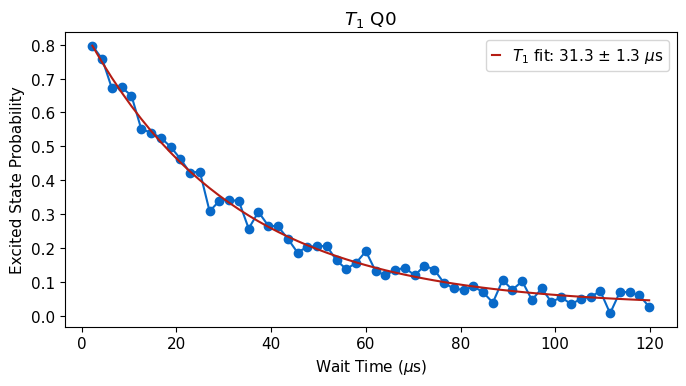

*Set cfg qubit 0 T1 to 31.32 from 32.89*


In [14]:
qi=0
qubit_tuning.get_coherence(meas.T1Experiment,qi=qi,cfg_dict=cfg_dict,par='T1')

## Echo

In [ ]:
qubit_list = np.arange(20)
qubit_list=[14]
for qi in qubit_list:
    #status, t2e = tuneup.get_coherence(cfg.make_t2e, i, cfg_dict,'T2e', min_r2=min_r2,tol=tol, max_t1=max_t1)
    t2e = meas.RamseyEchoExperiment(cfg_dict, qi=qi, params={'ramsey_freq':'smart'})
    if t2e.status:
        auto_cfg = config.update_qubit(cfg_path, 'T2e', t2e.data['best_fit'][3], qi,sig=2, rng_vals=[1.5, max_t1*2])

### Get echo coherence

In [ ]:
qi=6
t2e = qubit_tuning.get_coherence(meas.RamseyEchoExperiment, qi, cfg_dict,'T2e')

# Other

## Chi

In [ ]:
# Need a tuned up pi pulse for this
#for i in range(num_qubits):
qubit_list = [7]
for qi in qubit_list: 
    chi, chi_val=tuneup.check_chi(cfg_dict, qi)
    auto_cfg = config.update_readout(cfg_path, 'chi', float(chi_val), qi)
#auto_cfg = config.update_readout(cfg_path, 'frequency', float(chi.data['freq_opt']), i)

# Stark

### Ramsey

#### Single experiment

In [ ]:
qi=2
meas.RamseyStarkExperiment(cfg_dict, qi=qi, params={'stark_gain':1,'step':0.01,'df':40})

In [ ]:
auto_cfg = config.load(cfg_path)
def quad_fit(x, a, b, c):
    return a*x**2 + b*x + c
max_freq = []
max_freq_neg = []
alpha = np.array(auto_cfg.device.qubit.f_ge) - np.array(auto_cfg.device.qubit.f_ef)
df_pos = 45 
df_neg = 50
for i in range(len(auto_cfg.stark.l)):
    max_freq.append(quad_fit(1, auto_cfg.stark.q[i], auto_cfg.stark.l[i], auto_cfg.stark.o[i]))
    max_freq_neg.append(quad_fit(1, auto_cfg.stark.qneg[i], auto_cfg.stark.lneg[i], auto_cfg.stark.oneg[i]))
    
coef_pos = alpha/(alpha+df_pos)
coef_neg = alpha/(alpha-df_neg)
fig, ax = plt.subplots(2,1, figsize=(7,7))
ax[0].plot(max_freq,'o')
ax[0].plot(max_freq_neg,'o')

ax[1].plot(coef_pos,'o')
ax[1].plot(coef_neg,'o')

#### Sweep frequency

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[0]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':0.22, 'start_df':70, 'end_df':300, 'expts_df':25})

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[0]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':0.23, 'start_df':70, 'end_df':300, 'expts_df':25})

#### Calibrate stark power positive freq

In [ ]:
qubit_list = np.arange(20)
qubit_list=[0]
d=[]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':100, 'start_gain':0.05, 'end_gain':0.3})
    d.append(t2rstark)
    config.update_stark(cfg_path, 'q', t2rstark.data['quad_fit'][0], qi)
    config.update_stark(cfg_path, 'l', t2rstark.data['quad_fit'][1], qi)
    config.update_stark(cfg_path, 'o', t2rstark.data['quad_fit'][2], qi)

#### Negative frequency

In [ ]:
#qubit_list = np.arange(20)
d=[]
qubit_list=[0]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':-90, 'start_gain':0.05, 'end_gain':0.2, 'soft_avgs':2})
    d.append(t2rstark)
    config.update_stark(cfg_path, 'qneg', t2rstark.data['quad_fit'][0], qi)
    config.update_stark(cfg_path, 'lneg', t2rstark.data['quad_fit'][1], qi)
    config.update_stark(cfg_path, 'oneg', t2rstark.data['quad_fit'][2], qi)
#handy.plot_many(d, title='Ramsey Stark', save_path=cfg_dict['expt_path'])

### T1

#### Single exp

In [ ]:
t1 = meas.T1StarkExperiment(cfg_dict, qi=1, params={'active_reset':True, 'df':100}) 

#### Gain sweep

In [ ]:
qi=0
t1 = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':-90,'start_gain':0.02,'end_gain':0.17,'start':5, 'span':100})#, 'start':100,'span':0.34, 'expts':100, 'soft_avgs':3})

#### Freq sweep

In [ ]:
t1 = meas.T1StarkFreqExperiment(cfg_dict, qi=0, params={'reps':800, 'span':0.5, 'expts':150, 'span_f':50, 'start_df':50})

In [ ]:
len(t1.data['avgi'])
len(t1.data['avgi'][0])

np.max(t1.data['avgi'], axis=1)
plt.figure()
plt.plot(np.max(t1.data['avgi'], axis=1))

#### Single linear power sweep

In [ ]:
t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=0, params={"soft_avgs":4})

#### Run linear scan for multiple qubits

In [ ]:
#first, need to configure active reset and check stark for all. 
nexp = 3
qubit_list =[1,2]#2,4,5,6,7]
expts = 200
t1_data = [[] for _ in qubit_list]

for i in range(nexp):
    for j, qi in enumerate(qubit_list):
        t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=qi, params={ "soft_avgs":2,'expts':100})
        t1_data[j].append(t1_cont.data['t1'])

plt.figure()
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
for i, qi in enumerate(qubit_list):
    ax[i].set_title(f'Q{qi}')
    ax[i].pcolormesh(t1_data[i])
    plt.colorbar(ax[i].collections[0], ax=ax[i])


In [ ]:
plt.figure()
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
for i, qi in enumerate(qubit_list):
    ax[i].set_title(f'Q{qi}')
    ax[i].pcolormesh(t1_data[i])
    plt.colorbar(ax[i].collections[0], ax=ax[i])

In [ ]:
t1 = meas.T1StarkPowerContTimeExperiment(cfg_dict, qi=0, params={'count':2, 'gain_expts':10})

#### Run loop sweep trying to sweep frequency linearly 

In [ ]:
d=[]
for i in range(5):
    t1stark=meas.T1StarkPowerQuadSingle(cfg_dict, qi=0, params={'stop_f':20, 'df_pos':200, 'df_neg':-90})
    d.append(t1stark)

concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(1, len(d))], axis=1)

#print(concatenated_data)

plt.figure()
plt.pcolormesh(concatenated_data)

#### Calib sweep

In [ ]:
d=[]
phase = []
for i in range(300):
    if i % 12 == 0:
        shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        config.update_readout(cfg_path, 'threshold',shot.data['thresholds'][0], qi);
        config.update_readout(cfg_path, 'phase', shot.data['angle'], qi);
        phase.append(shot.data['angle'])

    t1stark=meas.T1StarkPowerQuadMulti(cfg_dict, qi=0, params={'stop_f':25, 'df_pos':100, 'df_neg':-90, 'active_reset':True})
    d.append(t1stark)

concatenated_data = np.concatenate([d[i].data['avgi_2'] for i in range(0, len(d))], axis=1)

#print(concatenated_data)

plt.figure()
plt.pcolormesh(concatenated_data)

In [154]:
f=[d[i].data['avgi'] for i in range(1, len(d))]

In [ ]:
len(d)

In [ ]:
concatenated_data.shape

In [ ]:
concatenated_data.shape

In [188]:
times = [d[i].data['start_time'] for i in range(0, len(d))] 
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)

In [ ]:
from datetime import datetime

# Convert the first element of times to a datetime object

tm = [datetime.strptime(times[i].decode('utf-8'), '%Y-%m-%d %H:%M:%S') for i in range(len(times))]
time_from_first = [(t - tm[0]).total_seconds() for t in tm]
print(time_from_first)

In [ ]:
concatenated_data()

In [ ]:
plt.figure()
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)
import matplotlib.dates as mdates

plt.pcolormesh(np.array(time_from_first)/60/60, d[-1].data['f_pts'], concatenated_data)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
#plt.gcf().autofmt_xdate()


In [ ]:
plt.figure()
plt.pcolormesh(concatenated_data)
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(1, len(d))], axis=1)


In [161]:
cd0 = np.concatenate([d[i].data['avgi_0'] for i in range(0, len(d))], axis=1)
cd1 = np.concatenate([d[i].data['avgi_1'] for i in range(0, len(d))], axis=1)
cd2 = np.concatenate([d[i].data['avgi_2'] for i in range(0, len(d))], axis=1)
cd3 = np.concatenate([d[i].data['avgi_3'] for i in range(0, len(d))], axis=1)

In [ ]:
import numpy as np

combined_cd = np.stack((cd0, cd1, cd2, cd3), axis=-1)
print(combined_cd.shape)

In [165]:
tms=d[0].data['wait_times']

In [ ]:
sns.set_palette('coolwarm',len(combined_cd))
from scipy.optimize import curve_fit
plt.figure()
def t1_fit(x, a, b, c):
    return b * np.exp(-x / c) + a
fits=[]
tm_full = np.linspace(0, tms[3])
#for i in range(5):
for i in range(len(combined_cd)):
    plt.plot(tms, combined_cd[i][0][:],'o-')
    p0 = (np.min(combined_cd[i][0][:]), np.max(combined_cd[i][0][:])-np.min(combined_cd[i][0][:]), tms[2])
    popt, err = curve_fit(t1_fit, tms, combined_cd[i][0][:], p0=p0)
    fit_err = np.sqrt(np.diag(err))   
    if np.mean(fit_err/np.abs(popt))>0.5:
        fits.append(np.nan*np.ones(3))   
    else:
        fits.append(popt)
    #print(p0)
    #plt.plot(tm_full, t1_fit(np.array(tm_full), *popt),'k', label=f'Fit {i}')
    #print(popt)
#plt.legend()


In [183]:
t1_data = [fits[i][2] for i in range(len(fits))]    
offset = [fits[i][0] for i in range(len(fits))]
amp = [fits[i][1] for i in range(len(fits))]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(8, 7))
ax[0].plot(t1_data, 'o-')
ax[1].plot(offset, 'o-')
ax[2].plot(amp, 'o-')

In [ ]:
cd0.shape

In [ ]:
d[0].data.keys()

In [367]:
dlist = [d[i].data['avgi'] for i in range(1,len(d))]

In [ ]:
concatenated_data.shape

In [ ]:
import numpy as np

# Concatenate all d[i].data['avgi'] into a single dataset
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(1, len(d))], axis=1)

#print(concatenated_data)

plt.figure()
plt.pcolormesh(concatenated_data)

## 2 Qubit

In [ ]:
t12q = meas.T1_2Q(cfg_dict, qi=[10,0], params={'active_reset':True})

In [ ]:
rabi2q = meas.Rabi_2Q(cfg_dict, qi=[10,0], params={'active_reset':True})

## Single Shot

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving C:\_Data\LLotsa\Tuning_2025_01_11\single_shot_qubit_0_00193.h5


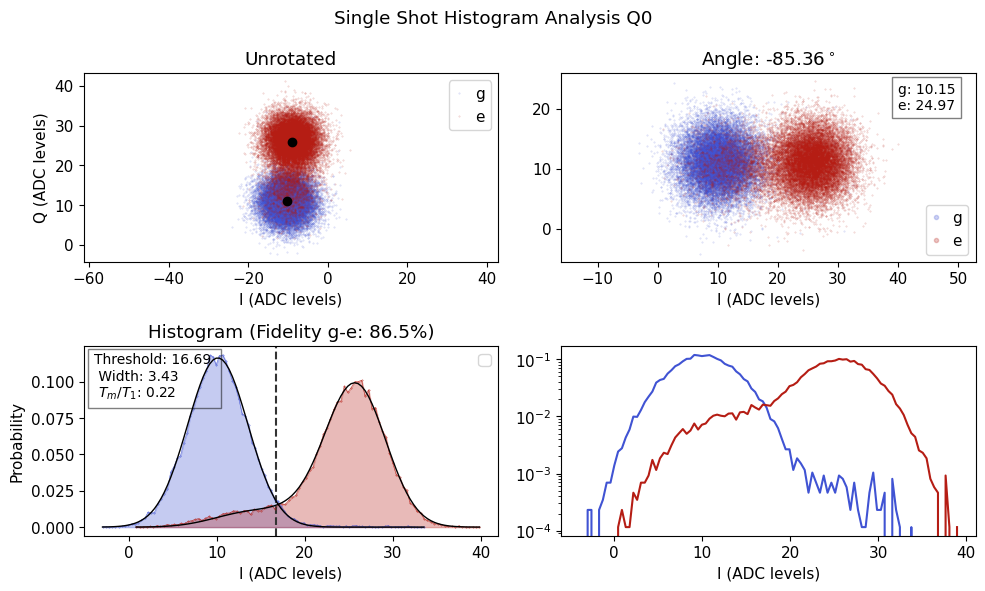

ge Fidelity (%): 86.524
Rotation angle (deg): -85.360
Threshold ge: 16.692
*Set cfg readout 0 phase to -85.3596 from -84.0108*
*Set cfg readout 0 threshold to 16.6924 from 16.5061*
*Set cfg readout 0 fidelity to 0.8652 from 0.8571*
*Set cfg readout 0 sigma to 3.4256 from 3.4381*
*Set cfg readout 0 tm to 0.2206 from 0.235*


In [15]:
# Single shot 
qubit_list = np.arange(0,20)
qubit_list =[0]
for qi in qubit_list: 
    shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
    config.update_readout(cfg_path, 'phase', shot.data['angle'], qi);
    config.update_readout(cfg_path, 'threshold',shot.data['thresholds'][0], qi);
    config.update_readout(cfg_path, 'fidelity', shot.data['fids'][0], qi);
    config.update_readout(cfg_path, 'sigma', shot.data['sigma'], qi);
    config.update_readout(cfg_path, 'tm', shot.data['tm'],qi);

### Adjust reps for fidelity 

In [ ]:
max_inc = 15 # dont' let it do more than 15x standard number of reps sot hat thtings don't take forever
auto_cfg = config.load(cfg_path)
qubit_list = [0]
for qi in qubit_list:
    config.update_readout(cfg_path, 'reps', 1/auto_cfg['device']['readout']['fidelity'][qi]**1.5, qi, rng_vals=[1,max_inc]);

### Active reset

#### Check active reset at standard threshold

In [ ]:
# Setup reset uses the calibrated angle and runs active reset process at end, but also uses usual final_delay so that it's ok if reset not working
qubit_list = np.arange(20)
qubit_list=[0]

d=[]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':70000,'active_reset':True, 'setup_reset':True})
    shot.check_reset()
    config.update_readout(cfg_path, 'reset_e', shot.data['reset_e'], qi)
    config.update_readout(cfg_path, 'reset_g', shot.data['reset_g'], qi)
    d.append(shot)

#### Sweep threshold

In [ ]:
d = []
qi=0
auto_cfg = config.load(cfg_path)
threshold = auto_cfg['device']['readout']['threshold'][qi]
thresh = np.linspace(threshold-25,threshold+25,6)
#thresh = np.linspace(threshold-10,threshold+10,6)
for t in thresh:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':120000,'threshold_v':t, 'active_reset':True,'setup_reset':True})
    d.append(shot)
    shot.check_reset()


In [ ]:
# Check how many qubits meet certain thresholds for success of reset. 
reset_e = [d[i].data['reset_e'] for i in range(len(d))]
reset_g = [d[i].data['reset_g'] for i in range(len(d))]

plt.figure()
plt.semilogy(reset_e,'o')
plt.axhline(y=0.15, color='r', linestyle='--')
plt.semilogy(reset_g,'ro')
plt.semilogy(np.array(reset_g)/np.array(reset_e), 'ko')
plt.axhline(y=1, color='r', linestyle='--')
#plt.show()

#### Turn off active reset for all config chans

In [ ]:
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',False, qi)

#### Turn on active reset for channels where it seems to be working

In [ ]:
e_success = 0.15 # Ratio of e proportion after active reset compared to before
g_vs_e = 2 # Ratio of g proportion to e proportion after active reset

auto_cfg = config.load(cfg_path)
reset_e = auto_cfg['device']['readout']['reset_e']
reset_g = auto_cfg['device']['readout']['reset_g']
result = np.array(reset_e)< e_success | np.array(reset_g)/np.array(reset_e)<g_vs_e
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',bool(result[qi]), qi)

#### Check reset (plotting result of reset)

In [ ]:
qubit_list = np.arange(11,20)

for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':50000,'active_reset':True})
    shot.check_reset()

### Readout opt

#### General sweep

In [ ]:
qubit_list=np.arange(12,20)
qubit_list=[1]

update=True
params = {'expts_f':1, 'expts_gain':9, 'expts_len':9}
for qi in qubit_list: 
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params=params, style='fine')
    if update:
        config.update_readout(cfg_path, 'gain', shotopt.data['gain'], qi);
        config.update_readout(cfg_path, 'readout_length', shotopt.data['length'], qi);
        config.update_readout(cfg_path, 'frequency', shotopt.data['freq'], qi);

#### Run optimization until it converges

In [ ]:
qubit_list=np.arange(7)
qubit_list=[7]
params = {'expts_f':1, 'expts_gain':5, 'expts_len':5}
qubit_tuning.meas_opt(cfg_dict, qubit_list, params)

#### Play with LO power

In [ ]:
qi = 11
gain_vals = [0.0375,0.05] 
for gain in gain_vals:
    config.update_lo(cfg_path, 'gain', gain, qi)
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params={'npts_f':5, 'npts_gain':5, 'npts_len':5})

In [ ]:
auto_cfg = config.load(cfg_path)

tmv = shotopt.data['tm'][0]
tmv[tmv<0.001]=np.nan
sns.set_palette('coolwarm', len(tmv))
fig, ax = plt.subplots(2,1, figsize=(8,6))
#tm = np.transpose(tmv)
for i, tm_arr in enumerate(tmv):
    gain=shotopt.data['gainpts'][i]
    ax[0].plot(shotopt.data['lenpts'],shotopt.data['lenpts']/tm_arr,'o-', label=f"{gain:.2f}")
#ax[0].legend()
ax[0].set_xlabel('Readout Length')
ax[0].axhline(y=auto_cfg.device.qubit.T1[shotopt.cfg.expt.qubit[0]], color='k', linestyle='--', label='T1')
ax[0].set_ylabel('$T_m/(T_m/T_1)$')

sigma = shotopt.data['sigma'][0]

for i, s in enumerate(sigma):
    gain=shotopt.data['gainpts'][i]
    ax[1].loglog(shotopt.data['lenpts'],s,'o-', label=f"{gain:.2f}")
ax[1].legend()
ax[1].set_xlabel('Readout Length')
ax[1].set_ylabel('$\sigma$')
fig.tight_layout()

# EF 

In [ ]:
## Compare expected EF to actual
auto_cfg = config.load(cfg_path)

alpha=np.array(auto_cfg.device.qubit.f_ef)-np.array(auto_cfg.device.qubit.f_ge)
corr = np.array([188,210,168,186,155,171,187,145,157,169,188,210,168,186,155,171,187,145,157,169])

alpha+corr

#f_ef=np.array(auto_cfg.device.qubit.f_ge)-corr
#f_ef
#6,7,8, 11 16 18

### Initial setting of frequencies based on guess for alpha

In [ ]:
# Initial set of the frequencyies based on guess for alpha 
alpha = -180
qubit_list = np.arange(20)
auto_cfg = config.load(cfg_path)
for i in qubit_list: 
    f_ge = auto_cfg['device']['qubit']['f_ge'][i]
    auto_cfg = config.update_qubit(cfg_path, 'f_ef', f_ge+alpha, i)

## Spectroscopy

### General search

In [ ]:
qubit_list= np.arange(1,20)
bad_qubits=[]
qubit_list=[0]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='medium', freq='ef')
    if not status:
        bad_qubits.append(qi)

### Specific width

In [ ]:
# You may want to update this frequency, which will be the center of the scan. 
#style huge, coarse, medium, fine 
update=True
qubit_list = np.arange(10)
for qi in qubit_list:
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'checkEF':True})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})
    if update and qspec.status:
        auto_cfg = config.update_qubit(cfg_path, 'f_ef', float(qspec.data["best_fit"][2]), qi)

## Rabi

In [ ]:
# If first time, initialize the sigma and gain to those of the ge 
first_time =False
update=True

qubit_list = np.arange(1,20)
qubit_list=[0]

bad_qubits = []
auto_cfg = config.load(cfg_path)

for qi in qubit_list: 
    if first_time:
        #config.update_qubit(cfg_path, 'f_ef', auto_cfg.device.qubit.f_spec_ef[qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','sigma'), auto_cfg['device']['qubit']['pulses']['pi_ge']['sigma'][qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), auto_cfg['device']['qubit']['pulses']['pi_ge']['gain'][qi], qi)
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'checkEF':True})
    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), amp_rabi.data['pi_length'], qi)
    else:
        print(f'Amplitude Rabi fit failed for qubit {qi}')
        bad_qubits.append(qi)

## Qubit Temperature

In [ ]:
qubit_list = np.arange(1)
qubit_list=[0]
for qi in qubit_list: 
    temp, pop = tuneup.measure_temp(cfg_dict, qi=qi)
    auto_cfg = config.update_qubit(cfg_path, 'temp', float(temp), qi)
    auto_cfg = config.update_qubit(cfg_path, 'pop', float(pop), qi)

## Ramsey EF

In [ ]:
qubit_list=np.arange(1,20)
qubit_list=[10]
for qi in qubit_list:
    t2r = meas.RamseyExperiment(cfg_dict, qi=qi, params={'ramsey_freq':0.2, 'checkEF':True, 'span':20})

    if t2r.status:
        config.update_qubit(cfg_path, 'f_ef', t2r.data['new_freq'], qi)
        #auto_cfg = config.update_qubit(cfg_path, 'T2r', t2r.data['best_fit'][3], qi, rng_vals=[1.5, max_t1], sig=2)
    else:
        print('T2 Ramsey fit failed')